In [1]:
from ziggurat import Exponential
from basic_rand import LCG

from matplotlib import pyplot as plt
import numpy as np

### Создадим генератор случайной величины

In [2]:
gen = LCG()

### Начальные параметры для гистограмм

In [3]:
def get_bins_count(n):
    return int(np.sqrt(n))


n = 100000
segments = get_bins_count(n)

## Проверим генератор базовой случайной величины

### Равномерность

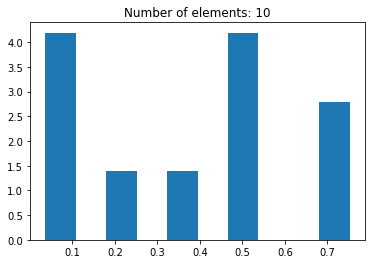

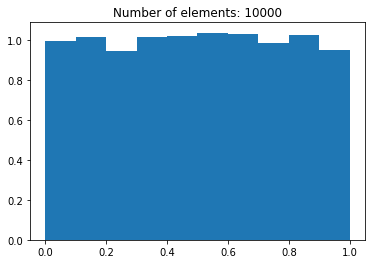

In [4]:
def test_uniformity(gen, iterations):
    vals = []
    for n in iterations:
        z = [gen.next_float() for _ in range(n)]
        vals.append(plt.hist(z, density=True)[0] / n)
        vals[-1] -= 1 / len(vals[-1])
        plt.title('Number of elements: {0}'.format(n))
        plt.show()
    
    # for each column plot differense with 1 / k
    vals = np.array(vals)
    nbins = len(vals[0])
    for i in range(nbins):
        plt.plot(vals[:, i], label=str(i))
    
    plt.legend()
    plt.show()
    
test_uniformity(gen, [10, 100, 1000, 10000])

### Независимость

In [5]:
def test_independence(gen, iterations):
    r = []
    for n in iterations:
        s = n // 3
        z = np.array([gen.next() for _ in range(n)])
        mx = sum(z) / float(n)
        dx = sum((z - mx) ** 2) / float(n - 1)

        
        if n == 10:
            for i in range(n - s):
                print(z[i], z[i + s])
            
        mxy = sum(z[i] * z[i + s] for i in range(n - s)) / float(n - s)
        r.append((mxy - mx * mx) / dx)
    print('Correlation coefficient:')
    print('\n'.join(["n: {}, ksi: {:.5}".format(num,c) for num, c in list(zip(iterations, r))]))
    
test_independence(gen, [10, 100, 1000, 10000])

7.369624540588761e+18 3.258265898418026e+18
5.500103319360215e+18 1.160642921532275e+19
1.4180852308020814e+19 8.75495945781912e+18
3.258265898418026e+18 1.3307016193876285e+19
1.160642921532275e+19 6.970581477325417e+18
8.75495945781912e+18 2.5908696256226752e+17
1.3307016193876285e+19 8.743403777448325e+18
Correlation coefficient:
n: 10, ksi: 0.056038
n: 100, ksi: 0.20673
n: 1000, ksi: 0.015001
n: 10000, ksi: -0.0044102


## Проверим генератор, преобразующий БСВ в Экспоненциально распределённую величину

### Равноинтервальная гистограмма (экспоненциальное распределение)

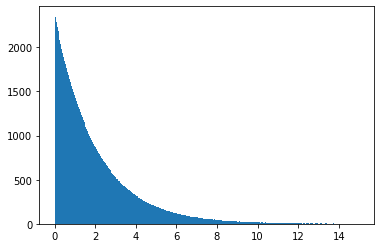

In [6]:
par = Exponential()
res = []
ranges = (0,15)
theta = 0.5

for _ in range(n):
    res.append(par.next(theta))


vals, bins, patches = plt.hist(res, bins=segments, range=ranges)

### Эмпирическая функция распределения

In [7]:
x_var = sorted(res)
x_var_f = [x for x in x_var if x >= ranges[0] and x <= ranges[1]]
counts = {}
for x in x_var:
    counts[x] = counts.get(x, 0) + 1
    
F = [0]
for i in range(len(x_var) - 1):
    F.append(F[i] + counts[x_var[i]] / n)

def distr_fun(x):
    for i in range(1, len(x_var)):
        if x_var[i - 1] <= x < x_var[i]:
            return F[i - 1]
    return 1

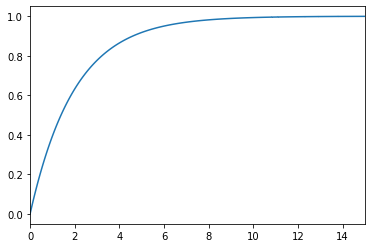

In [8]:
plt.xlim(ranges)
plt.step(sorted(res), F)

### Равновероятностная гистограмма

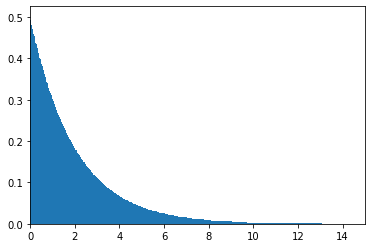

In [9]:
borders_eq = [x_var[0]] + [(x_var[i] + x_var[i + 1]) / 2 for i in range(n // segments - 1, n - 1, n // segments)] + [x_var[-1]]

#print(borders_eq)

_ = plt.xlim(ranges)
_, _, _ = plt.hist(x_var, bins=borders_eq, density=True)
#plt.plot(res, H)

### точечная оценка матожидания

In [10]:
m_p = np.sum(x_var) / n
print(m_p)

1.9996531858812305


### точечная оценка дисперсии

In [11]:
d_p = np.sum((x_var - m_p)**2) / (n - 1)
print(d_p)

3.9934215544064076


### подсмотренные на википедии для λ=0.5: МО=2, дисперсия=4

### Функция Лапласа

In [12]:
import scipy.stats

laplace = [(x, scipy.stats.norm.cdf(x) - 0.5) for x in np.arange(0, 5, 0.01)]

def find_x_laplace(u):
    good_x = 0
    min_d = 10
    for x, y in laplace:
        if abs(u - y) < min_d:
            min_d = abs(u - y)
            good_x = x
    return good_x

print(find_x_laplace(0.4418))

1.57


### Доверитальные интервалы матожидания

In [13]:
def get_interval(s, val, n):
    return s * find_x_laplace(val) / np.sqrt(n)

In [14]:
alphas = np.arange(0.01, 0.31, 0.005)
laplaces = (1 - alphas) / 2
lens = []
for i in range(len(laplaces)):
    interval_len = 2 * get_interval(np.sqrt(d_p), laplaces[i], n)
    lens.append(interval_len)

plt.ylabel('Interval Length')
plt.xlabel('Alpha')
plt.plot(alphas, lens)

plt.show()

### довериельный интервал дисперсии

In [15]:
from scipy.stats import chi2

def build_sample(n):
    res = []
    for i in range(n):
        res.append(par.next(theta))

    x_var = sorted(res)
    return x_var
    
def get_dispersion_intervals(s_sqr, alpha, n):
    return s_sqr * (n - 1) / chi2.ppf(1 - alpha / 2, n - 1), s_sqr * (n - 1) / chi2.ppf(alpha / 2, n - 1)

def get_dispersion_intervals_known(s_sqr, alpha, n):
    return s_sqr * n / chi2.ppf(1 - alpha / 2, n), s_sqr * n / chi2.ppf(alpha / 2, n)

def build_solution_dispersion(n):
    x_var = build_sample(n)
    m_p = np.sum(x_var) / n
    d_p = np.sum((x_var - m_p)**2) / (n - 1)
    alphas = np.arange(0.01, 0.31, 0.005)
    lens = []
    for i in range(len(laplaces)):
        l, r = get_dispersion_intervals(d_p, alphas[i], n)
        lens.append(r - l)

    plt.title('n = {0}'.format(n))
    plt.ylabel('Interval Length')
    plt.xlabel('Alpha')
    plt.plot(alphas, lens)
    
    plt.show()

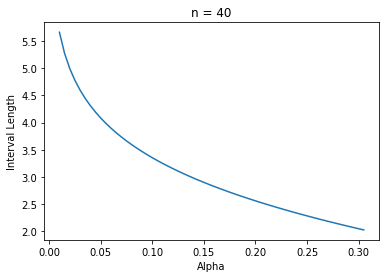

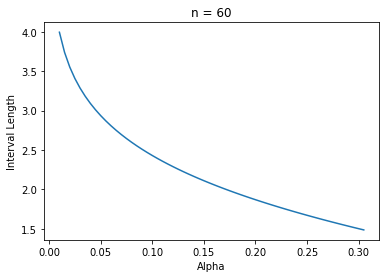

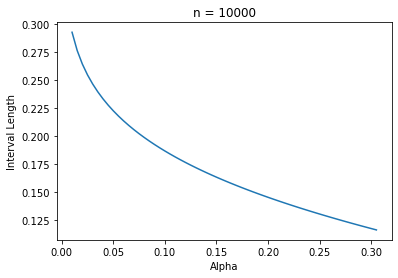

In [16]:
for i in [40, 60, 100, 200, 10000]:
    build_solution_dispersion(i)

### Точечная оценка медианы

In [17]:
def find_median(bins, vals):
    med_amount = sum(vals) / 2
    h = bins[1] - bins[0]
    cur_sum = 0
    i = 0
    while cur_sum < med_amount:
        cur_sum += vals[i]
        i += 1
        #print('cur: ', cur_sum)
    
    #print(bins)
    #print(vals)
    #print(med_amount)
    #print(cur_sum - vals[i])
    #print(i)
    return bins[i] + h * (med_amount - cur_sum + vals[i]) / vals[i]

med_p = find_median(bins, vals)
print(med_p)

1.4317074848651623


### Точечная оценка моды

In [18]:
def find_mode(bins, vals):
    mode_pos = 0
    max_val = 0
    h = bins[1] - bins[0]
    
    for i, val in enumerate(vals):
        if val > max_val:
            max_val = val
            mode_pos = i
   
    prev_pos = i - 1 if i - 1 >= 0 else 0
    next_pos = i + 1 if i + 1 < len(vals) else 0
    
    return bins[mode_pos] + h * (vals[mode_pos] - vals[prev_pos]) / (vals[mode_pos] - vals[prev_pos] + vals[mode_pos] - vals[next_pos])

mod_p = find_mode(bins, vals)
print(mod_p)

0.04746835443037975


In [19]:
def get_median_confidense(x_var, a=0.05):
    n = len(x_var)
    if a == 0.1:
        k = 0.5 * (n - 1.64 * np.sqrt(n) - 1)
    if a == 0.05:
        k = 0.5 * (n - 1.96 * np.sqrt(n) - 1)
    if a == 0.01:
        k = 0.5 * (n - 2.58 * np.sqrt(n) - 1)
    
    k = int(k)
    print(k, n - k + 1)
    return x_var[k], x_var[n - k + 1]

get_median_confidense(x_var_f)

49662 50284


(1.3728157955008171, 1.3976764098054513)

### Проверим критерий согласия Пирсона

In [20]:
from pprint import pprint
import math

# distribution function
def get_F(theta):
    def F(x):
        return 1 - math.exp(-theta * x) if x >= 0 else 0
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(len(bins) - 1):
        l = bins[i]
        r = bins[i + 1]
        pi_s = F(r) - F(l)
        pi = vals[i] / n
        if pi == 0: continue
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)


from scipy.stats import chi2

chi_sqr = pearson_chi(bins, vals, get_F(theta))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 0.10636578975474704, Table chi square: 276.7514409808032
Good


## Проверим самописный генератор распределения случайной величины

In [21]:
from card_shuffle import CardShuffleChoice
from matplotlib import pyplot as plt
import math
import numpy as np

In [22]:
def get_bins_count(n):
    if n <= 100:
        return int(np.sqrt(n))
    else:
        return 10 * int(np.log10(n))

_lambda = 1
n = 10000
segments = get_bins_count(n)

In [23]:
def poisson_distrib(_lambda: int, k: int) -> list:
    poisson = []
    for i in range(k):
        poisson.append(math.exp(-_lambda) * _lambda**i / math.factorial(i))
    return poisson

values = [i for i in range(0, 8)]
possibilities = poisson_distrib(_lambda, 8)

card_shuffle = CardShuffleChoice(values, possibilities)

def build_sample(n):
    res = []
    for i in range(n):
        res.append(card_shuffle.next())

    x_var = sorted(res)
    return x_var

x_var = build_sample(n)

### Равноинтервальная гистограмма

In [24]:
vals, bins, _ = plt.hist(x_var)

### Равновероятностная гистограмма

d:\projects\py\mmod\venv\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


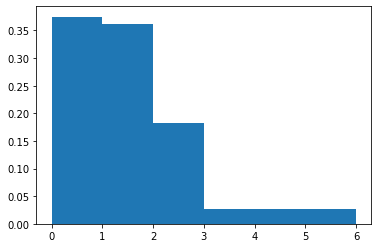

In [25]:
borders_eq = [x_var[0]] + [(x_var[i] + x_var[i + 1]) / 2 for i in range(n // segments - 1, n - 1, n // segments)] + [x_var[-1]]

vals_int, bins_int, patches_int = plt.hist(x_var, bins=borders_eq, density=True)

### Найдем точечное значение матожидания случайной величины

In [26]:
m_p = np.sum(x_var) / n
print(m_p)

0.9949


### найдём точечное значение дисперсии

In [27]:
d_p = np.sum((x_var - m_p)**2) / (n - 1)
print(d_p)

1.00997498749875


### График зависимости интервала матожидания от доверительной вероятности 1 - α

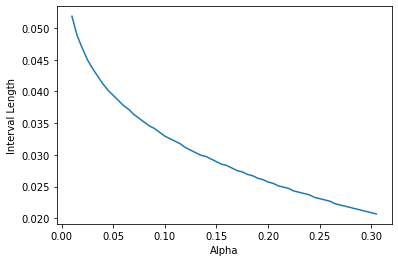

In [28]:
alphas = np.arange(0.01, 0.31, 0.005)
laplaces = (1 - alphas) / 2
lens = []
for i in range(len(laplaces)):
    interval_len = 2 * get_interval(np.sqrt(d_p), laplaces[i], n)
    lens.append(interval_len)

plt.ylabel('Interval Length')
plt.xlabel('Alpha')
plt.plot(alphas, lens)

plt.show()

### Довериетельный интервал для дисперсии

In [29]:
from scipy.stats import chi2

In [30]:
def get_dispersion_intervals(s_sqr, alpha, n):
    return s_sqr * (n - 1) / chi2.ppf(1 - alpha / 2, n - 1), s_sqr * (n - 1) / chi2.ppf(alpha / 2, n - 1)

def get_dispersion_intervals_known(s_sqr, alpha, n):
    return s_sqr * n / chi2.ppf(1 - alpha / 2, n), s_sqr * n / chi2.ppf(alpha / 2, n)

def build_solution_dispersion(n):
    x_var = build_sample(n)
    m_p = np.sum(x_var) / n
    d_p = np.sum((x_var - m_p)**2) / (n - 1)
    alphas = np.arange(0.01, 0.31, 0.005)
    lens = []
    for i in range(len(laplaces)):
        l, r = get_dispersion_intervals(d_p, alphas[i], n)
        lens.append(r - l)

    plt.title('n = {0}'.format(n))
    plt.ylabel('Interval Length')
    plt.xlabel('Alpha')
    plt.plot(alphas, lens)
    
    plt.show()

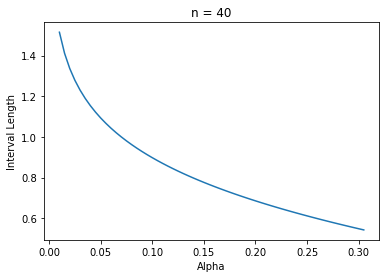

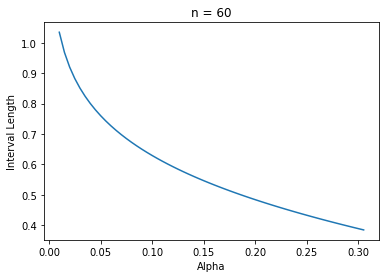

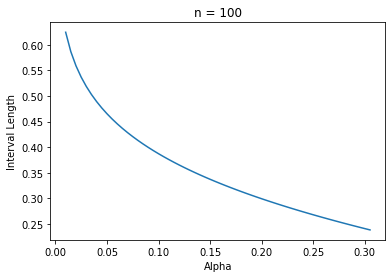

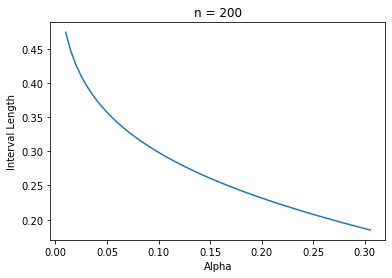

In [31]:
for i in [40, 60, 100, 200]:
    build_solution_dispersion(i)

### Критерий согласия Пирсона

In [32]:
def get_F(lambda_):
    def F(x):
        x = int(x)
        return math.exp(-_lambda) * _lambda**x / math.factorial(x)
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(int(bins[0]), int(bins[-1])):
        pi_s = F(i)
        pi = vals[i] / n
        if pi == 0: continue
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)

In [33]:
chi_sqr = pearson_chi(bins, vals, get_F(_lambda))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 1.5102845815497241, Table chi square: 4.574813079322224
Good
